# Importando bibliotecas e dataset 

In [1]:
# Adicionando ao path para facilitar importações de arquivos
import sys
sys.path.append('../')

In [2]:
# Descomente a linha abaixo na primeira execução, caso não possua o `pt_core_news_lg`
# !python -m spacy download pt_core_news_lg

In [3]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import openai
import pandas as pd
import re
import seaborn as sns
import spacy
import string

from LeIA import (
    SentiText, 
    SentimentIntensityAnalyzer as LeIASentimentIntensityAnalyzer,
    PACKAGE_DIRECTORY,
    BOOSTER_DICT,
    NEGATE,
)
from nltk.sentiment import SentimentIntensityAnalyzer
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

import pt_core_news_lg

pd.options.display.max_colwidth = 100

In [4]:
file_path = '../data/raw/ErikakHilton-tweets.csv'
raw_df = pd.read_csv(file_path, on_bad_lines='skip', sep=';', encoding='utf-8')

/tmp/ipykernel_29439/726023801.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(file_path, on_bad_lines='skip', sep=';', encoding='utf-8')


In [5]:
raw_df.shape

(22505, 49)

# Pré processamento

## Filtrar tweets
Vamos remover tweets repetidos e filtrar uma amostra menor, para facilitar a comparação manual de resultados

In [6]:
duplicated_indexes = raw_df[raw_df.duplicated()].index
df = raw_df.drop(duplicated_indexes)
df.shape

(20505, 49)

In [7]:
sample_df = df[:100]

# Análise de Sentimento

## Avaliação Manual

Avaliação manual do sentimento dos tweets, para comparar com as outras

In [8]:
manual_sentiment = [0, 0.05, 0.05, 0, 0, 0, 0, 0.05, 0, -0.1, -0.05, 0, 0.1, 0.2, 0.1, 0, 0.2, -0.05, -0.1, 0.8, 0.6, -0.05, 0.3, 0.9, -0.2, 0.1, 0.4, 0, 0, -0.3, -0.2, -0.2, 0.3, 0.1, 0.2, 0.1, 0.3, -0.05, -0.05, 0.1, 0.9, -0.05, 0.05, 0.5, 0.2, 0.6, 0, 0.7, -0.1, 0, 0, -0.2, 0, 0.1, 0, 0.1, 0.1, 0, -0.5, 0, 0, 0.7, 0.05, 0.1, 0.5, 0.2, 0.2, 0.2, -0.1, -0.05, -0.1, -0.2, 0.2, -0.05, 0, -0.05, 0.05, 0, -0.1, -0.2, -0.2, -0.15, -0.2, 0.1, 0, -0.05, -0.2, -0.15, 0, -0.05, 0.1, -0.05, 0.05, -0.05, 0.05, 0.05, 0.05, -0.05, 0, -0.3,]
sample_df['manual_sentiment_score'] = manual_sentiment

/tmp/ipykernel_29439/2620526826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['manual_sentiment_score'] = manual_sentiment


## LeIA Sentiment Intensity Analysis

LeIA (Léxico para Inferência Adaptada) é uma adaptação da analise de intensidade de sentimento do Vader para o português

In [9]:
from src.models import CustomSentimentIntensityAnalyzer

# sia = LeIASentimentIntensityAnalyzer()
sia = CustomSentimentIntensityAnalyzer()

def leia_sentiment_analysis(text):
    return sia.polarity_scores(text)

scores = sample_df['rawContent'].apply(leia_sentiment_analysis)
sample_df['leia_sentiment_neg'] = scores.apply(lambda score: score['neg'])
sample_df['leia_sentiment_neu'] = scores.apply(lambda score: score['neu'])
sample_df['leia_sentiment_pos'] = scores.apply(lambda score: score['pos'])
sample_df['leia_sentiment_score'] = scores.apply(lambda score: score['compound'])

/tmp/ipykernel_29439/3389700561.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['leia_sentiment_neg'] = scores.apply(lambda score: score['neg'])
/tmp/ipykernel_29439/3389700561.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['leia_sentiment_neu'] = scores.apply(lambda score: score['neu'])
/tmp/ipykernel_29439/3389700561.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Checando a proporção de termos conhecidos e desconhecidos avaliados nos tweets

In [10]:
print(f'{sia.used_lexicon_count()=}')
print(f'{sia.used_emojis_count()=}')
print(f'{sia.used_modifiers_count()=}')
print(f'{sia.unknown_words_count()=}')
print(f'{sia.known_words_proportion()=}')

sia.used_lexicon_count()=89
sia.used_emojis_count()=0
sia.used_modifiers_count()=2
sia.unknown_words_count()=922
sia.known_words_proportion()=0.08983218163869694


In [11]:
# Aplicando no dataset todo para checar a cobertura do lexico
sia = CustomSentimentIntensityAnalyzer()

def leia_sentiment_analysis(text):
    return sia.polarity_scores(text)

scores = df['rawContent'].apply(leia_sentiment_analysis)

print(f'{sia.used_lexicon_count()=}')
print(f'{sia.used_emojis_count()=}')
print(f'{sia.used_modifiers_count()=}')
print(f'{sia.unknown_words_count()=}')
print(f'{sia.known_words_proportion()=}')

sia.used_lexicon_count()=20249
sia.used_emojis_count()=0
sia.used_modifiers_count()=624
sia.unknown_words_count()=171641
sia.known_words_proportion()=0.10842328350145963


In [12]:
# Termos não encontrados mais frequents
sorted(sia.unknown_words.items(), key=lambda item: item[1], reverse=True)[:10]

[('@erikakhilton', 18783),
 ('de', 4362),
 ('que', 4140),
 ('em', 2482),
 ('bolsonaro', 2423),
 ('do', 2233),
 ('lula', 2157),
 ('no', 1713),
 ('da', 1662),
 ('na', 1623)]

## Avaliação do ChatGPT
Vamos usar a API do ChatGPT para gerar outra análise de sentimentos, para comparar os resultados.

In [13]:
from src.config import OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY

In [14]:
"""
Estava tentando um resultado mais elaborado, mas as respostas estão muito inconsistentes. 
Acho que vale a pena tentar otimizar os prompts para respostas mais precisas e bem explicadas
"""
# base_msg = (
#     "Você é meu assistente de PLN e fará uma análise de sentimentos nos tweets que eu mandar. "
#     "Os tweets serão enviados no formato CSV com duas colunas (separadas por ;;):\n - Id do tweet\n - Texto do tweet\n\n"
#     "Para cada tweet você deve gerar um score de -1 (extremamente negativo) a 1(extremamente positivo), com até 4 casas decimais.\n"
#     "Sua resposta deve vir no formato de um arquivo CSV com três colunas (separadas por ;;):\n"
#     " - Id do tweet\n - Score de sentimentos do tweet\n - Breve explicação do score\n\n"
#     "Aqui vão os tweets para análise:\n"
# )

# def get_chatgpt_tweet_input(tweet):
#     return f"{tweet.id};;{tweet.rawContent}"

# tweets_input = sample_df[:10].apply(get_chatgpt_row_input, axis=1).values
# tweets_input = '\n'.join(tweets_input)

# msg = base_msg + tweets_input
# print(msg)
# print('\n\n')

# completion = openai.ChatCompletion.create(
#     model="gpt-3.5-turbo",
#     messages=[{"role": "user", "content": msg}],
#     temperature=0,
# )

# print(completion.choices[0].message.content)

'\nEstava tentando um resultado mais elaborado, mas as respostas estão muito inconsistentes. \nAcho que vale a pena tentar otimizar os prompts para respostas mais precisas e bem explicadas\n'

In [15]:
base_msg = (
    "Você é meu assistente de PLN e irá realizar uma análise de sentimentos no tweet que eu enviar. "
    "Você deve gerar um score de sentimento de -1 (extremamente negativo) a 1(extremamente positivo), com até 4 casas decimais. "
    "Sua resposta deve conter apenas o número do score de sentimento."
    "Tweet: "
)

# raw_chatgpt_sentiment_score = []
# for tweet in tqdm(sample_df['rawContent']):
#     msg = base_msg + tweet    
#     completion = openai.ChatCompletion.create(
#         model="gpt-3.5-turbo",
#         messages=[{"role": "user", "content": msg}],
#         temperature=0,
#     )

#     raw_chatgpt_sentiment_score.append(completion.choices[0].message.content)
    
    
# Backup dos valores, para poupar requests à API
raw_chatgpt_sentiment_score =  ['-0.8750', '0.8750', '0.8', '0.0', '0.0', '0.8', '0.0', '0.4583', '0.0', '-0.7847', '-0.8571', '0.0', '0.7788', '0.7', 'Score de sentimento: 0.0', '0.9', '0.8750', '-0.5714', '-0.9365', '0.8750', '0.8750', '-0.5', '0.8750', '1.0', '-0.8571', '0.6364', '0.4583', '-0.7845', 'Desculpe, mas não é possível realizar a análise de sentimento sem o conteúdo do tweet. Por favor, envie o tweet completo para que eu possa gerar o score de sentimento.', '-0.7143', '-0.9365', '-0.8571', '0.8750', '1.0', '0.4583', '0.9375', '0.4583', '-0.3333', '-0.8571', '0.8750', '0.9365', '-0.5714', '0.4583', '0.8750', '0.8750', '0.7782', '0.9', '0.9712', '-0.8571', '0.5', '0.2', '-0.9365', 'Desculpe, mas não é possível realizar a análise de sentimentos sem o conteúdo do tweet. Por favor, envie o texto do tweet para que eu possa realizar a análise.', '1.0', 'Desculpe, mas não é possível realizar a análise de sentimentos sem o conteúdo do tweet. Por favor, envie o tweet completo para que eu possa gerar o score de sentimento.', '1.0', '0.5', '0.8', '-0.8', '0.75', '0.0', '0.8750', '0.4583', '0.4583', '0.9717', '0.9583', '0.4583', '1.0', '-0.8571', '0.5719', '-0.8571', '-0.4583', '0.4583', '0.0', '0.0', '-0.3333', '0.4583', '0.0', '-0.5422', '-0.7143', '0.8225', '0.4583', '-0.6789', '0.8225', '0.0', '-0.9369', '-0.8571', '0.0', '-0.3182', '-0.25', '0.8750', '0.0', '0.8750', '-0.8571', '0.4583', '0.0', '0.3182', '-0.8571', '0.8750', '-0.8571']

In [16]:
# O ChatGPT não consegue avaliar alguns tweets, por isso precisamos remover alguns dos resultados
def convert_score(raw_score):
    try:
        return float(score)
    except Exception as e:
        return None

chatgpt_sentiment_score = []
for score in raw_chatgpt_sentiment_score:
    chatgpt_sentiment_score.append(convert_score(score))
    
sample_df['chatgpt_sentiment_score'] = chatgpt_sentiment_score

/tmp/ipykernel_29439/769610907.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['chatgpt_sentiment_score'] = chatgpt_sentiment_score


In [17]:
def get_sentiment_from_score(score):
    if score <= -0.3:
        return "neg"
    if score < 0.3:
        return "neu"
    return "pos"

sample_df['manual_sentiment'] = sample_df['manual_sentiment_score'].apply(get_sentiment_from_score)
print(sample_df['manual_sentiment'].value_counts())

sample_df['leia_sentiment'] = sample_df['leia_sentiment_score'].apply(get_sentiment_from_score)
print(sample_df['leia_sentiment'].value_counts())

sample_df['chatgpt_sentiment'] = sample_df['chatgpt_sentiment_score'].apply(get_sentiment_from_score)
print(sample_df['chatgpt_sentiment'].value_counts())

neu    84
pos    13
neg     3
Name: manual_sentiment, dtype: int64
neu    65
pos    22
neg    13
Name: leia_sentiment, dtype: int64
pos    55
neg    30
neu    15
Name: chatgpt_sentiment, dtype: int64


/tmp/ipykernel_29439/213122004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['manual_sentiment'] = sample_df['manual_sentiment_score'].apply(get_sentiment_from_score)
/tmp/ipykernel_29439/213122004.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['leia_sentiment'] = sample_df['leia_sentiment_score'].apply(get_sentiment_from_score)
/tmp/ipykernel_29439/213122004.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

# Comparação de Resultados

Axes(0.125,0.11;0.775x0.77)


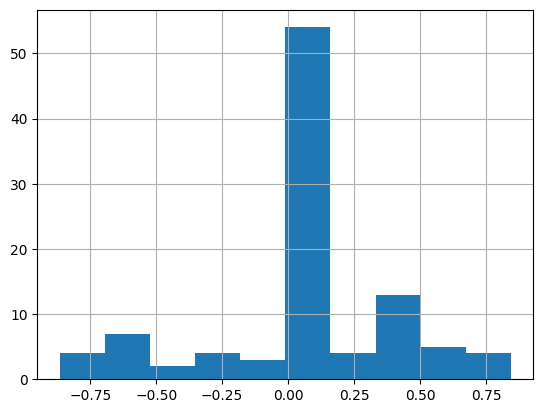

In [18]:
print(sample_df['leia_sentiment_score'].hist())

Axes(0.125,0.11;0.775x0.77)


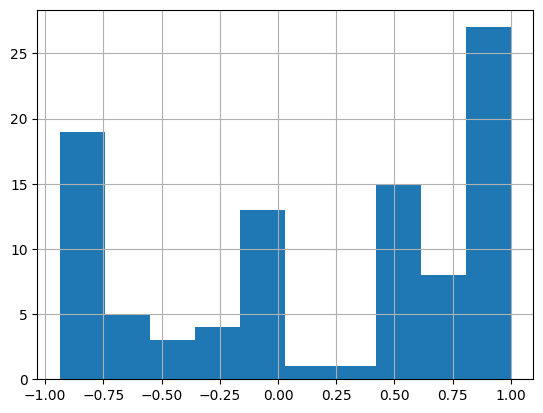

In [19]:
print(sample_df['chatgpt_sentiment_score'].hist())

Axes(0.125,0.11;0.775x0.77)


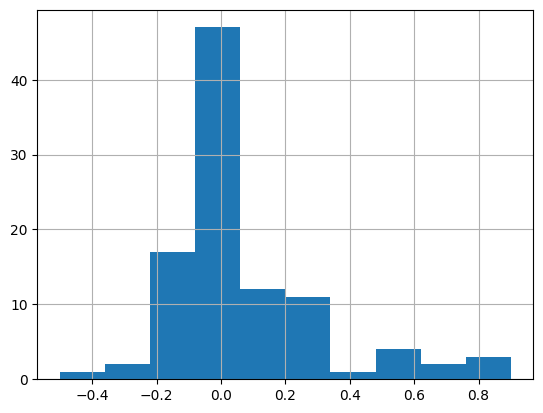

In [20]:
print(sample_df['manual_sentiment_score'].hist())

In [21]:
sample_df[['rawContent', 'leia_sentiment_score', 'leia_sentiment', 'chatgpt_sentiment_score', 'chatgpt_sentiment', 'manual_sentiment_score', 'manual_sentiment']]

,rawContent,leia_sentiment_score,leia_sentiment,chatgpt_sentiment_score,chatgpt_sentiment,manual_sentiment_score,manual_sentiment
0,"Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada...",0.2023,neu,-0.8750,neg,0.00,neu
1,@ErikakHilton Simplesmente a maior ❤️❤️❤️ https://t.co/SBA5EPiN7k,0.6369,pos,0.8750,pos,0.05,neu
2,@PalasAthenas18 Hahahhaha 💜💜💜,0.0000,neu,0.8000,pos,0.05,neu
4,@ErikakHilton É isso aí...,-0.4215,neg,0.0000,neu,0.00,neu
5,@Mendes2588 🫶🏾🫶🏾,0.0000,neu,0.0000,neu,0.00,neu
...,...,...,...,...,...,...,...
103,@ErikakHilton @LulaOficial ouvimos amém,0.0000,neu,0.0000,neu,0.05,neu
104,@ErikakHilton @LulaOficial Isso já tá sendo tudo pra minha saúde mental. O silêncio.,0.0000,neu,0.3182,pos,0.05,neu
105,Cada hora de silêncio que passa só mostra o quão pequeno é um sujeito como Bolsonaro.\n\nQue sai...,0.0000,neu,-0.8571,neg,-0.05,neu
106,@ErikakHilton obrigada por tudo 💜,0.0000,neu,0.8750,pos,0.00,neu


In [22]:
sample_df[['rawContent', 'leia_sentiment_score', 'chatgpt_sentiment_score', 'manual_sentiment_score']]

,rawContent,leia_sentiment_score,chatgpt_sentiment_score,manual_sentiment_score
0,"Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada...",0.2023,-0.8750,0.00
1,@ErikakHilton Simplesmente a maior ❤️❤️❤️ https://t.co/SBA5EPiN7k,0.6369,0.8750,0.05
2,@PalasAthenas18 Hahahhaha 💜💜💜,0.0000,0.8000,0.05
4,@ErikakHilton É isso aí...,-0.4215,0.0000,0.00
5,@Mendes2588 🫶🏾🫶🏾,0.0000,0.0000,0.00
...,...,...,...,...
103,@ErikakHilton @LulaOficial ouvimos amém,0.0000,0.0000,0.05
104,@ErikakHilton @LulaOficial Isso já tá sendo tudo pra minha saúde mental. O silêncio.,0.0000,0.3182,0.05
105,Cada hora de silêncio que passa só mostra o quão pequeno é um sujeito como Bolsonaro.\n\nQue sai...,0.0000,-0.8571,-0.05
106,@ErikakHilton obrigada por tudo 💜,0.0000,0.8750,0.00


In [23]:
sample_df[['leia_sentiment_score', 'chatgpt_sentiment_score', 'manual_sentiment_score']].describe()

,leia_sentiment_score,chatgpt_sentiment_score,manual_sentiment_score
count,100.000000,96.000000,100.000000
mean,0.026309,0.164833,0.063000
std,0.353461,0.691747,0.243877
min,-0.865000,-0.936900,-0.500000
25%,0.000000,-0.549500,-0.050000
50%,0.000000,0.458300,0.000000
75%,0.220025,0.875000,0.100000
max,0.844200,1.000000,0.900000


### Métricas

In [24]:
# Necessário remover as linhas com None para calcular o erro
results_df = sample_df.dropna(subset=['leia_sentiment_score', 'leia_sentiment', 'chatgpt_sentiment_score', 'chatgpt_sentiment', 'manual_sentiment_score', 'manual_sentiment'])

In [25]:
# ChatGPT e LeIA
mae = mean_absolute_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['leia_sentiment_score']
)

mse = mean_squared_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['leia_sentiment_score']
)

r2 = r2_score(
    results_df['chatgpt_sentiment_score'], 
    results_df['leia_sentiment_score']
)

print('ChatGPT e LeIA')
print(f"MAE: {mae}")
print(f"MSE: {mse}")
# print(f"R2: {r2}")


# ChatGPT e Manual
mae = mean_absolute_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['manual_sentiment_score']
)

mse = mean_squared_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['manual_sentiment_score']
)

r2 = r2_score(
    results_df['chatgpt_sentiment_score'], 
    results_df['manual_sentiment_score']
)

print('\nChatGPT e Manual')
print(f"MAE: {mae}")
print(f"MSE: {mse}")
# print(f"R2: {r2}")


# LeIA e Manual
mae = mean_absolute_error(
    results_df['leia_sentiment_score'], 
    results_df['manual_sentiment_score']
)

mse = mean_squared_error(
    results_df['leia_sentiment_score'], 
    results_df['manual_sentiment_score']
)

r2 = r2_score(
    results_df['leia_sentiment_score'], 
    results_df['manual_sentiment_score']
)

print('\nLeIA e Manual')
print(f"MAE: {mae}")
print(f"MSE: {mse}")
# print(f"R2: {r2}")

ChatGPT e LeIA
MAE: 0.5050947916666667
MSE: 0.3723896509375

ChatGPT e Manual
MAE: 0.4878395833333333
MSE: 0.32652816104166665

LeIA e Manual
MAE: 0.259546875
MSE: 0.13653684697916665


## Analisando resultados do LeIA

In [26]:
# Checando quantas linhas não tiveram nenhum token por valencia
print(sample_df[sample_df['leia_sentiment_neg'] == 0].shape[0])
print(sample_df[sample_df['leia_sentiment_neu'] == 0].shape[0])
print(sample_df[sample_df['leia_sentiment_pos'] == 0].shape[0])

73
0
65


count    96.000000
mean      0.505095
std       0.344243
min       0.000000
25%       0.215000
50%       0.500000
75%       0.800000
max       1.496500
Name: abs_error_leia_chatgpt, dtype: float64


/tmp/ipykernel_29439/3322105043.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['abs_error_leia_chatgpt'] = abs(sample_df['chatgpt_sentiment_score'] - sample_df['leia_sentiment_score'])


<Axes: >

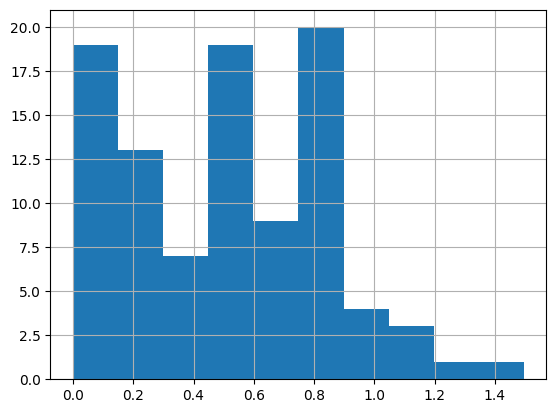

In [27]:
sample_df['abs_error_leia_chatgpt'] = abs(sample_df['chatgpt_sentiment_score'] - sample_df['leia_sentiment_score'])

print(sample_df['abs_error_leia_chatgpt'].describe())
sample_df['abs_error_leia_chatgpt'].hist()

count    100.000000
mean       0.250165
std        0.263222
min        0.000000
25%        0.050000
50%        0.200000
75%        0.387025
max        1.460000
Name: abs_error_leia_manual, dtype: float64


/tmp/ipykernel_29439/2485841093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['abs_error_leia_manual'] = abs(sample_df['manual_sentiment_score'] - sample_df['leia_sentiment_score'])


<Axes: >

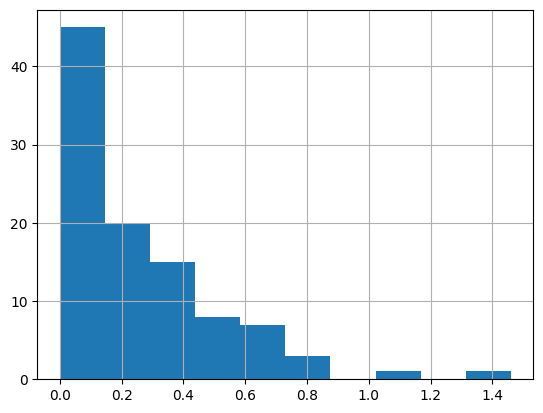

In [28]:
sample_df['abs_error_leia_manual'] = abs(sample_df['manual_sentiment_score'] - sample_df['leia_sentiment_score'])

print(sample_df['abs_error_leia_manual'].describe())
sample_df['abs_error_leia_manual'].hist()

count    96.00000
mean      0.48784
std       0.29912
min       0.00000
25%       0.25830
50%       0.50715
75%       0.75740
max       1.02250
Name: abs_error_chatgpt_manual, dtype: float64


/tmp/ipykernel_29439/3113420513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['abs_error_chatgpt_manual'] = abs(sample_df['manual_sentiment_score'] - sample_df['chatgpt_sentiment_score'])


<Axes: >

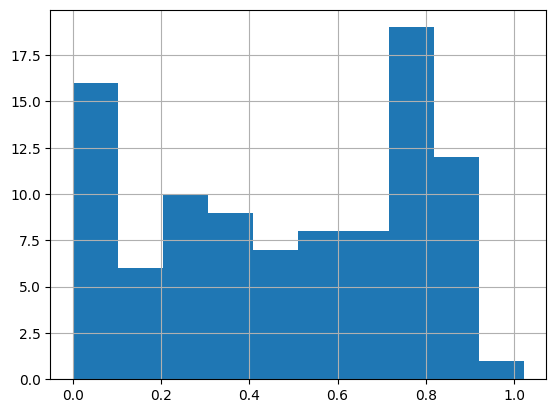

In [29]:
sample_df['abs_error_chatgpt_manual'] = abs(sample_df['manual_sentiment_score'] - sample_df['chatgpt_sentiment_score'])

print(sample_df['abs_error_chatgpt_manual'].describe())
sample_df['abs_error_chatgpt_manual'].hist()

### Distribuição da quantidade de palavras

/tmp/ipykernel_29439/1191727322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['word_count'] = sample_df['rawContent'].apply(get_word_count)


<Axes: xlabel='word_count', ylabel='Count'>

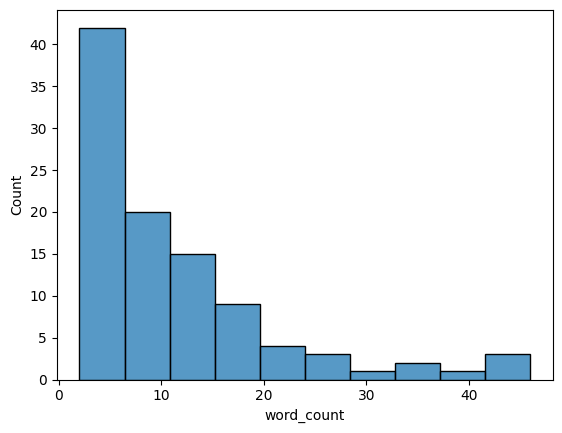

In [30]:
def get_word_count(text):
    words = text.split(" ")
    return len(words)

sample_df['word_count'] = sample_df['rawContent'].apply(get_word_count)

sns.histplot(data=sample_df["word_count"])

<Axes: xlabel='manual_sentiment', ylabel='Count'>

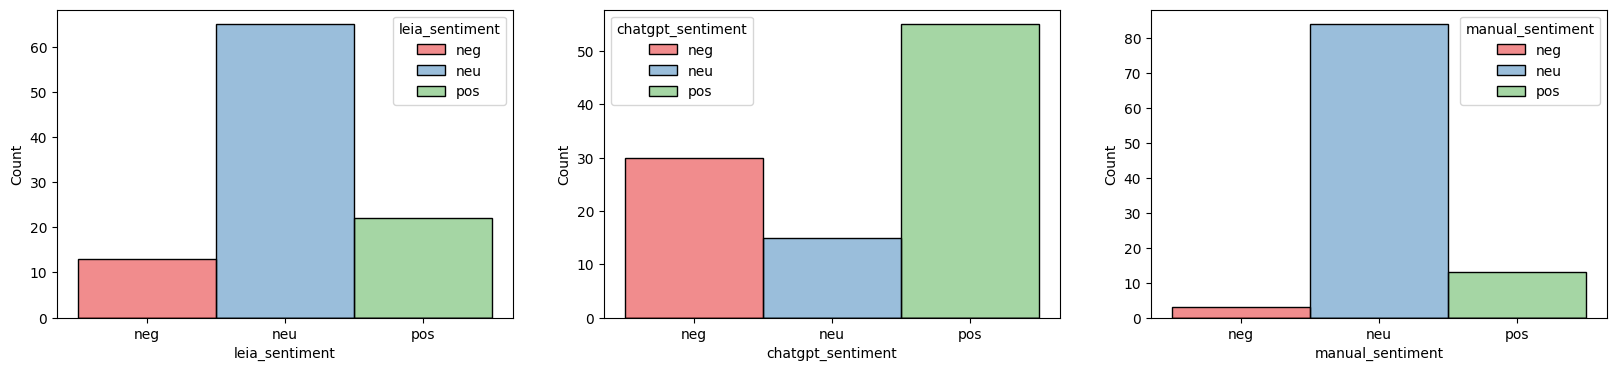

In [31]:
# Distribuição de sentimento
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

sns.histplot(
    data=sample_df.sort_values('leia_sentiment'), 
    x="leia_sentiment", 
    hue='leia_sentiment', 
    palette='Set1',
    ax=ax[0],
)

sns.histplot(
    data=sample_df.sort_values('chatgpt_sentiment'), 
    x="chatgpt_sentiment", 
    hue='chatgpt_sentiment',
    palette='Set1',
    ax=ax[1],
)

sns.histplot(
    data=sample_df.sort_values('manual_sentiment'), 
    x="manual_sentiment", 
    hue='manual_sentiment', 
    palette='Set1',
    ax=ax[2],
)

<Axes: xlabel='word_count', ylabel='Count'>

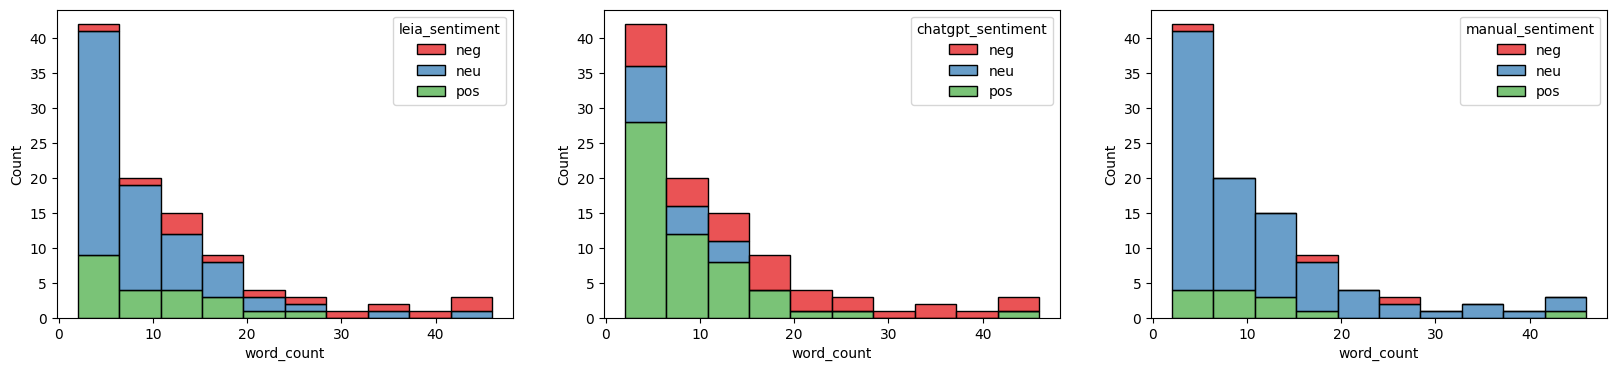

In [32]:
# Distribuição de word count segmentado pelo sentimento
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

sns.histplot(
    data=sample_df.sort_values('leia_sentiment'), 
    x="word_count", 
    hue='leia_sentiment', 
    multiple='stack',
    palette='Set1',
    ax=ax[0],
)

sns.histplot(
    data=sample_df.sort_values('chatgpt_sentiment'), 
    x="word_count", 
    hue='chatgpt_sentiment', 
    multiple='stack',
    palette='Set1',
    ax=ax[1],
)

sns.histplot(
    data=sample_df.sort_values('manual_sentiment'), 
    x="word_count", 
    hue='manual_sentiment', 
    multiple='stack',
    palette='Set1',
    ax=ax[2],
)

<Axes: xlabel='word_count', ylabel='Count'>

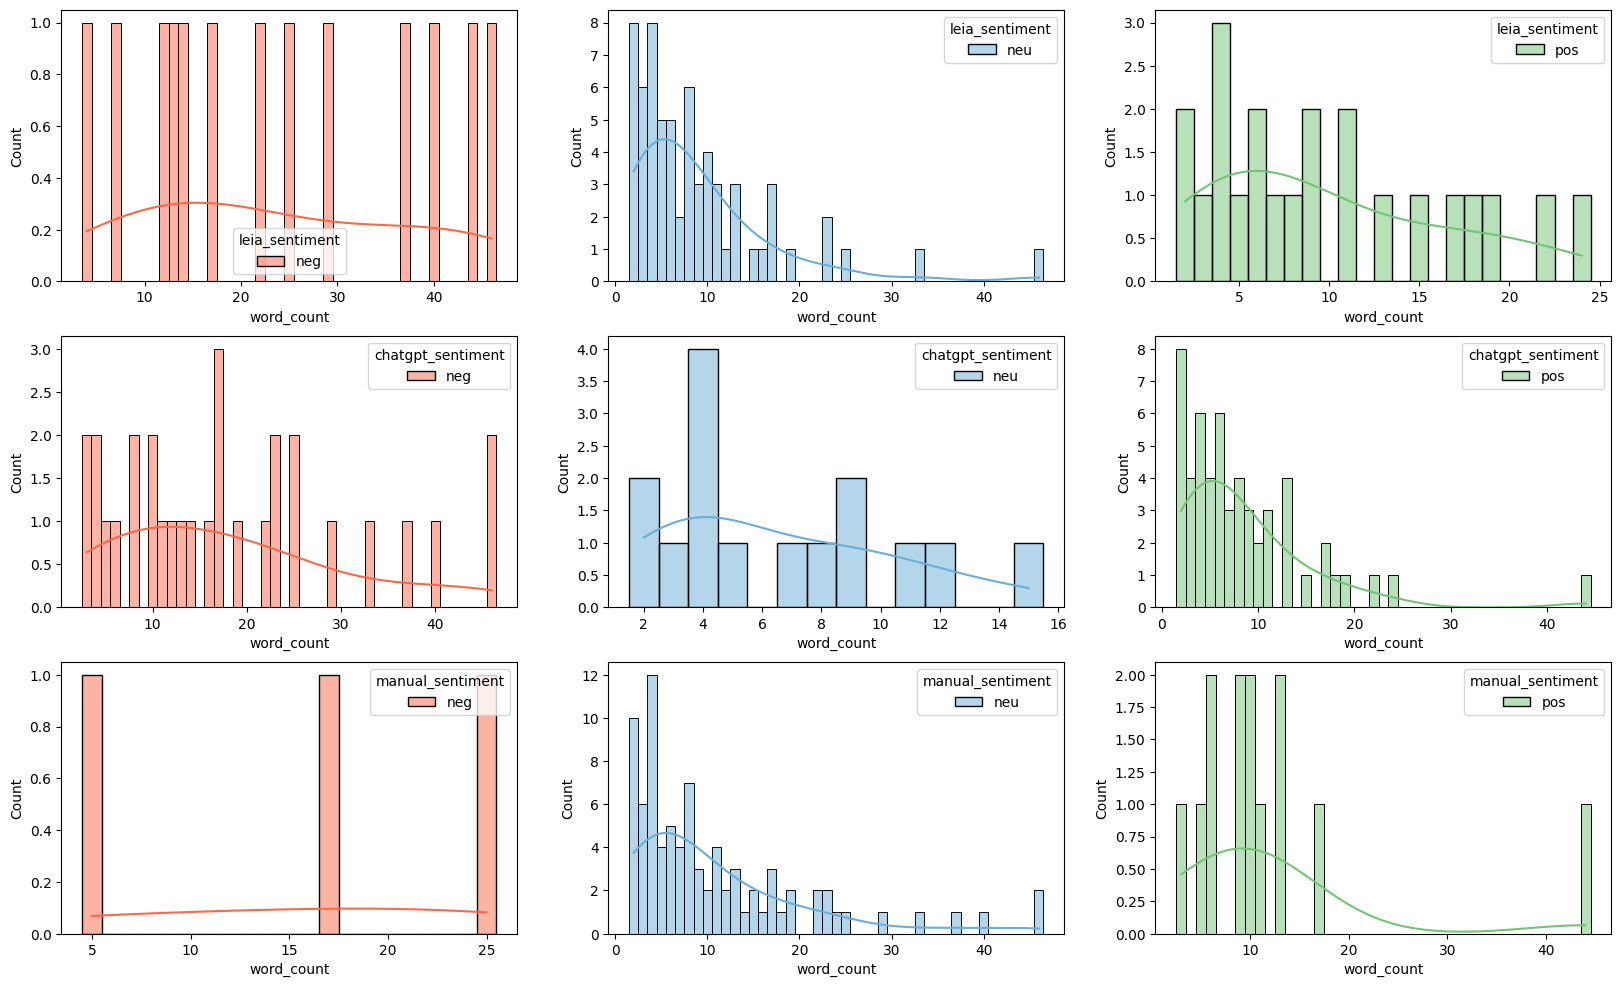

In [33]:
# Distribuição de word count segmentado pelo sentimento
fig, ax = plt.subplots(3, 3, figsize=(20, 12))

sns.histplot(
    data=sample_df[sample_df['leia_sentiment'] == 'neg'], 
    x="word_count", 
    hue='leia_sentiment', 
    discrete=True,
    ax=ax[0][0],
    kde=True,
    palette="Reds",
)

sns.histplot(
    data=sample_df[sample_df['leia_sentiment'] == 'neu'], 
    x="word_count", 
    hue='leia_sentiment', 
    discrete=True,
    palette='Blues',
    ax=ax[0][1],
    kde=True,
)

sns.histplot(
    data=sample_df[sample_df['leia_sentiment'] == 'pos'], 
    x="word_count", 
    hue='leia_sentiment', 
    discrete=True,
    palette='Greens',
    ax=ax[0][2],
    kde=True,
)

sns.histplot(
    data=sample_df[sample_df['chatgpt_sentiment'] == 'neg'], 
    x="word_count", 
    hue='chatgpt_sentiment', 
    discrete=True,
    ax=ax[1][0],
    kde=True,
    palette="Reds",
)

sns.histplot(
    data=sample_df[sample_df['chatgpt_sentiment'] == 'neu'], 
    x="word_count", 
    hue='chatgpt_sentiment', 
    discrete=True,
    palette='Blues',
    ax=ax[1][1],
    kde=True,
)

sns.histplot(
    data=sample_df[sample_df['chatgpt_sentiment'] == 'pos'], 
    x="word_count", 
    hue='chatgpt_sentiment', 
    discrete=True,
    palette='Greens',
    ax=ax[1][2],
    kde=True,
)

sns.histplot(
    data=sample_df[sample_df['manual_sentiment'] == 'neg'], 
    x="word_count", 
    hue='manual_sentiment', 
    discrete=True,
    ax=ax[2][0],
    kde=True,
    palette="Reds",
)

sns.histplot(
    data=sample_df[sample_df['manual_sentiment'] == 'neu'], 
    x="word_count", 
    hue='manual_sentiment', 
    discrete=True,
    palette='Blues',
    ax=ax[2][1],
    kde=True,
)

sns.histplot(
    data=sample_df[sample_df['manual_sentiment'] == 'pos'], 
    x="word_count", 
    hue='manual_sentiment', 
    discrete=True,
    palette='Greens',
    ax=ax[2][2],
    kde=True,
)

<Axes: xlabel='word_count', ylabel='abs_error_chatgpt_manual'>

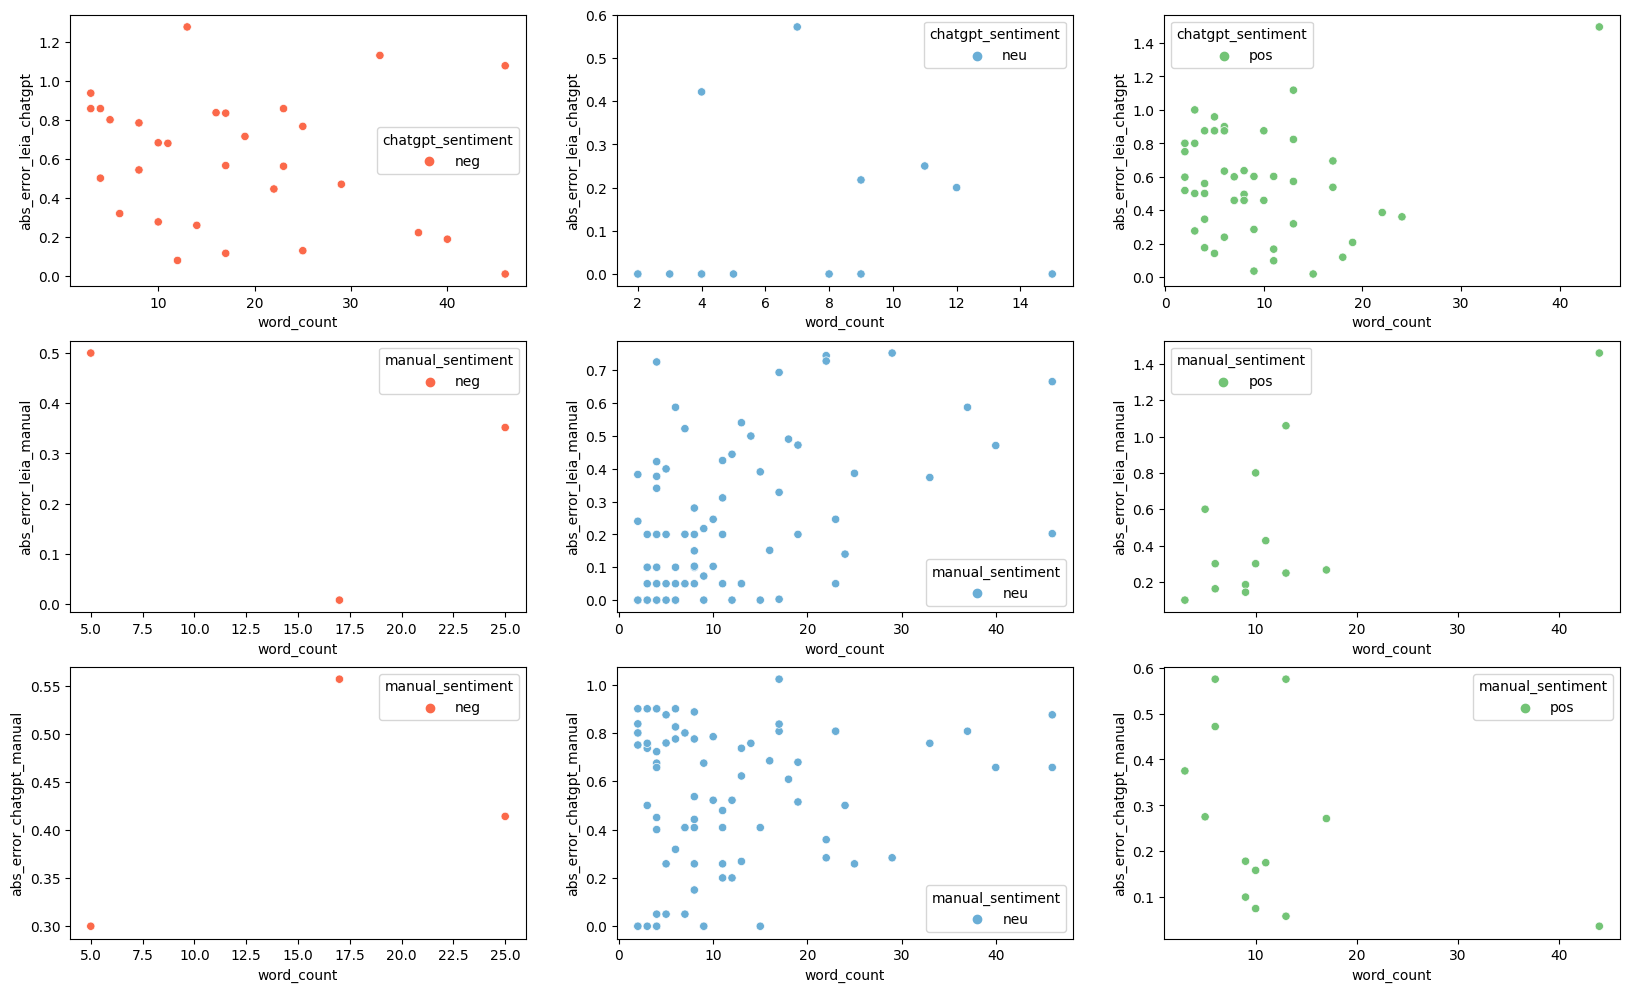

In [34]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))

sns.scatterplot(
    data=sample_df[sample_df['chatgpt_sentiment'] == 'neg'], 
    x="word_count", 
    y="abs_error_leia_chatgpt", 
    hue='chatgpt_sentiment', 
    palette='Reds',
    ax=ax[0][0],
)

sns.scatterplot(
    data=sample_df[sample_df['chatgpt_sentiment'] == 'neu'], 
    x="word_count", 
    y="abs_error_leia_chatgpt", 
    hue='chatgpt_sentiment', 
    palette='Blues',
    ax=ax[0][1],
)

sns.scatterplot(
    data=sample_df[sample_df['chatgpt_sentiment'] == 'pos'], 
    x="word_count", 
    y="abs_error_leia_chatgpt", 
    hue='chatgpt_sentiment', 
    palette='Greens',
    ax=ax[0][2],
)

sns.scatterplot(
    data=sample_df[sample_df['manual_sentiment'] == 'neg'], 
    x="word_count", 
    y="abs_error_leia_manual", 
    hue='manual_sentiment', 
    palette='Reds',
    ax=ax[1][0],
)

sns.scatterplot(
    data=sample_df[sample_df['manual_sentiment'] == 'neu'], 
    x="word_count", 
    y="abs_error_leia_manual", 
    hue='manual_sentiment', 
    palette='Blues',
    ax=ax[1][1],
)

sns.scatterplot(
    data=sample_df[sample_df['manual_sentiment'] == 'pos'], 
    x="word_count", 
    y="abs_error_leia_manual", 
    hue='manual_sentiment', 
    palette='Greens',
    ax=ax[1][2],
)


sns.scatterplot(
    data=sample_df[sample_df['manual_sentiment'] == 'neg'], 
    x="word_count", 
    y="abs_error_chatgpt_manual", 
    hue='manual_sentiment', 
    palette='Reds',
    ax=ax[2][0],
)

sns.scatterplot(
    data=sample_df[sample_df['manual_sentiment'] == 'neu'], 
    x="word_count", 
    y="abs_error_chatgpt_manual", 
    hue='manual_sentiment', 
    palette='Blues',
    ax=ax[2][1],
)

sns.scatterplot(
    data=sample_df[sample_df['manual_sentiment'] == 'pos'], 
    x="word_count", 
    y="abs_error_chatgpt_manual", 
    hue='manual_sentiment', 
    palette='Greens',
    ax=ax[2][2],
)

In [35]:
# sns.heatmap(
#     data=sample_df[['leia_sentiment_score', 'chatgpt_sentiment_score', 'manual_sentiment_score']], 
#     cmap=sns.color_palette("Spectral", as_cmap=True),
# )

## Salvando os resultados

In [36]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 107
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       100 non-null    object 
 1   date                      100 non-null    object 
 2   rawContent                100 non-null    object 
 3   renderedContent           100 non-null    object 
 4   id                        100 non-null    int64  
 5   user                      100 non-null    object 
 6   replyCount                100 non-null    int64  
 7   retweetCount              100 non-null    int64  
 8   likeCount                 100 non-null    int64  
 9   quoteCount                100 non-null    int64  
 10  conversationId            100 non-null    int64  
 11  lang                      100 non-null    object 
 12  source                    0 non-null      float64
 13  sourceUrl                 0 non-null      float64
 14  sourceLabe

In [40]:
output_path = '../data/processed/'
output_file = f'sentiment_analysis_comparison_output.csv'

# Para salvar os dados, descomente as linhas abaixo
sample_df.to_csv(f"{output_path}{output_file}", sep=';', encoding='utf-8', index=False)